In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [13]:
sns.set_theme(style="whitegrid")

In [4]:
data_dir = Path('/Users/suzinyou/workspace/inequality/data')

# 1 서울
⚠️주의: 서울시외 거주중인 사람이 일부 포함된 결과입니다. 

In [73]:
ds = pd.read_csv(data_dir / '01_descriptive_statistics' / 'bfc_seoul_desc_stat_yearonly.csv')

In [10]:
ds.head()

,STD_YYYY,var,count,nmiss,mean,max,min,std
0,2002,inc_wage,0,15807091,NaN,NaN,NaN,NaN
1,2003,inc_wage,3772718,12151505,2.358866e+07,4.713851e+10,1.0,4.261856e+07
2,2004,inc_wage,3841032,12211820,2.574970e+07,5.704411e+10,1.0,5.238302e+07
3,2005,inc_wage,3944226,12231104,2.732023e+07,6.014819e+10,1.0,5.792535e+07
4,2006,inc_wage,4149225,12168445,2.859317e+07,9.360000e+10,1.0,7.766723e+07


In [75]:
ds.loc[:, 'missing_frac'] = ds['nmiss'] / (ds['count'] + ds['nmiss'])

## 변수별 fraction of missing values

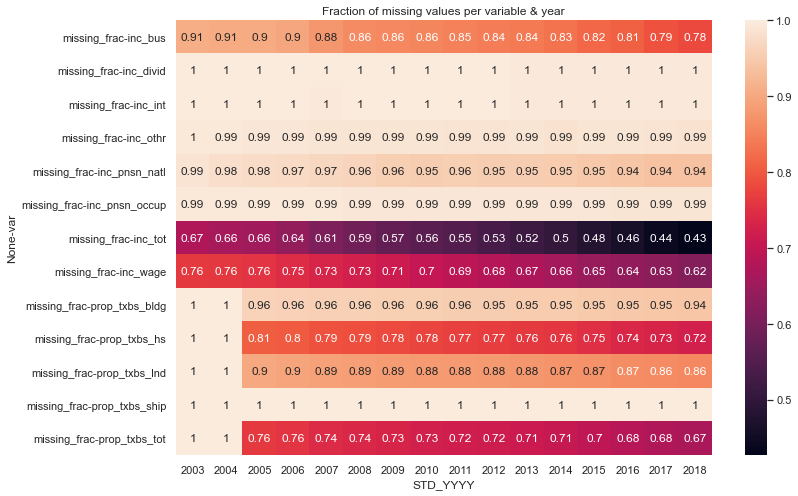

In [76]:
missing_matrix = ds.loc[
    ds['STD_YYYY'] > 2002, 
    ['var', 'STD_YYYY', 'missing_frac']
].pivot(index='STD_YYYY', columns='var').T
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Fraction of missing values per variable & year")
sns.heatmap(missing_matrix, annot=True, ax=ax);

## 평균 소득 및 과세표준

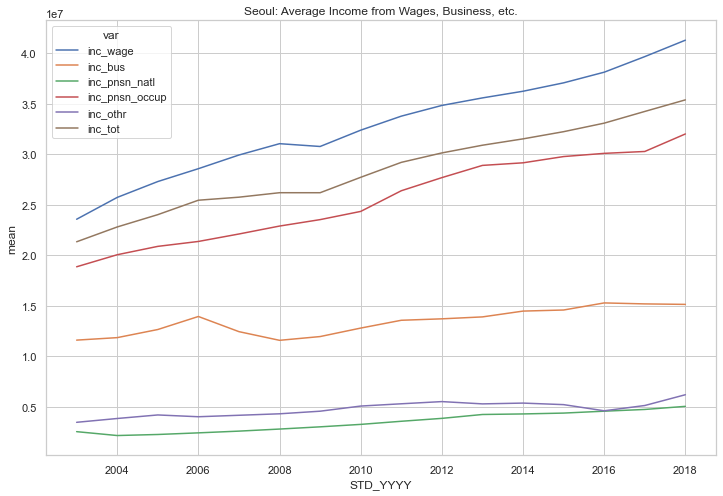

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Seoul: Average Income from Wages, Business, etc.")
sns.lineplot(x="STD_YYYY", 
             y="mean",
             hue="var", 
             data=ds[ds['var'].apply(
                 lambda x: x.startswith('inc') and x not in ['inc_int', 'inc_divid'])], 
             ax=ax
            );
# for _, df in ds.groupby('var'):
#     ax.fill_between(df['STD_YYYY'].unique(), df['mean'] - df['std'], df['mean'] + df['std'], alpha=0.3)

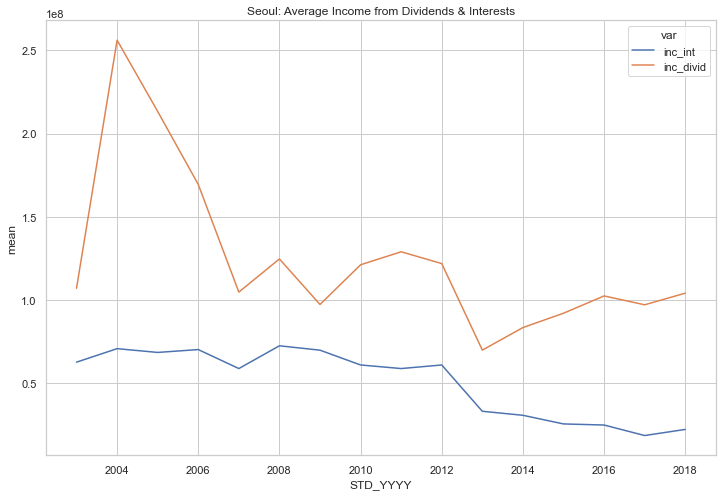

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Seoul: Average Income from Dividends & Interests")
sns.lineplot(x="STD_YYYY", y="mean",
             hue="var", data=ds[ds['var'].apply(lambda x: x in ['inc_int', 'inc_divid'])], ax=ax);

# 2 전국 (서울시 제외)

In [77]:
ds = pd.read_csv(data_dir / '01_descriptive_statistics' / 'bfc_smpl_desc_stat_yearonly.csv')
ds.loc[:, 'missing_frac'] = ds['nmiss'] / (ds['count'] + ds['nmiss'])

## 변수별 fraction of missing values

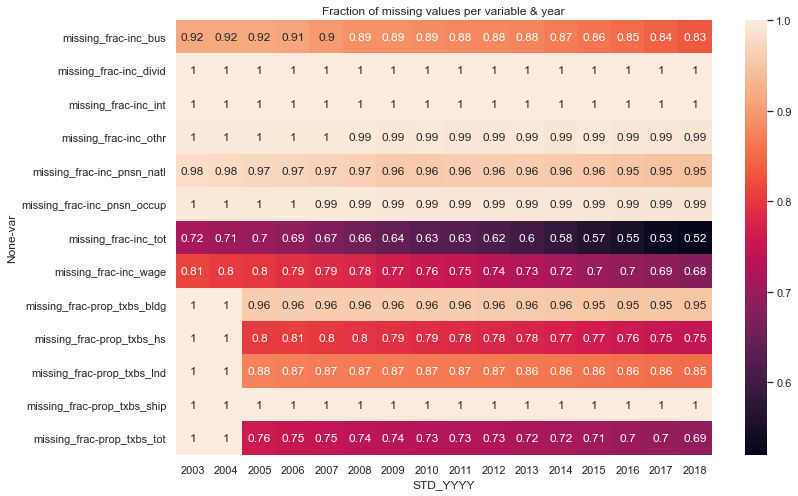

In [78]:
missing_matrix = ds.loc[
    ds['STD_YYYY'] > 2002, 
    ['var', 'STD_YYYY', 'missing_frac']
].pivot(index='STD_YYYY', columns='var').T
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Fraction of missing values per variable & year")
sns.heatmap(missing_matrix, annot=True, ax=ax);

## 평균 소득 및 과세표준

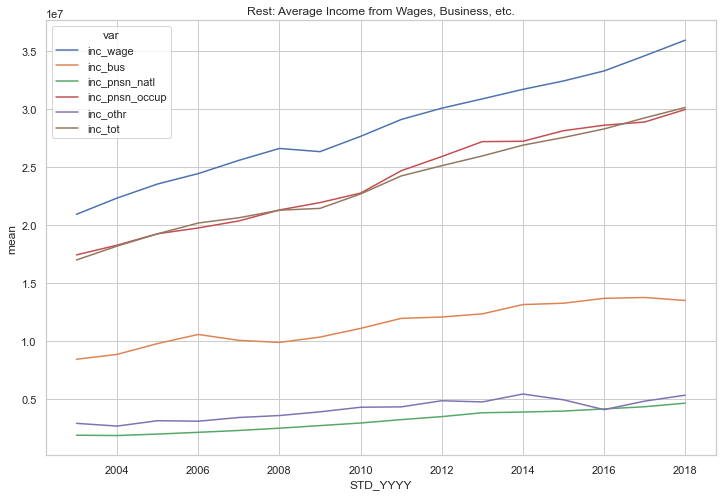

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Rest: Average Income from Wages, Business, etc.")
sns.lineplot(x="STD_YYYY", 
             y="mean",
             hue="var", 
             data=ds[ds['var'].apply(
                 lambda x: x.startswith('inc') and x not in ['inc_int', 'inc_divid'])], 
             ax=ax
            );
# for _, df in ds.groupby('var'):
#     ax.fill_between(df['STD_YYYY'].unique(), df['mean'] - df['std'], df['mean'] + df['std'], alpha=0.3)

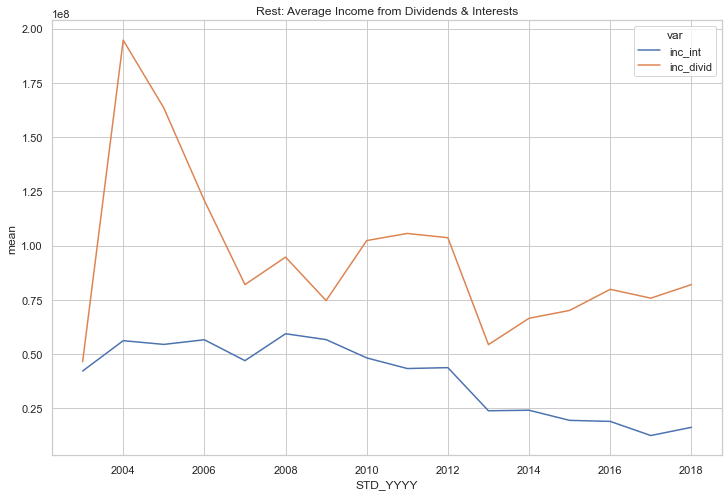

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Rest: Average Income from Dividends & Interests")
sns.lineplot(x="STD_YYYY", y="mean",
             hue="var", data=ds[ds['var'].apply(lambda x: x in ['inc_int', 'inc_divid'])], ax=ax);